In [15]:
import numpy as np
import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")  # alternative
base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt

from utils import remove_all_ticks_and_labels

device = 'cpu'

[None, (-3.0, 3.0), (-3.0, 3.0)]

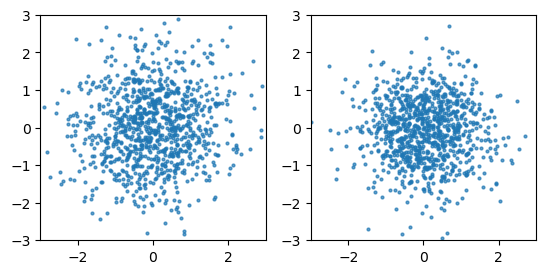

In [38]:
from prior_utils import diffused_sample
gt_manifold = generate_2d_swiss_roll(int(1e3), True, return_as_tensor=True)[1]

num_steps = 2000
diffused_x_2000 = diffused_sample(num_steps, num_steps-1, gt_manifold)

num_steps = 100
diffused_x_100 = diffused_sample(num_steps, num_steps-1, gt_manifold)

fig, ax = plt.subplots(1, 2)
ax[0].scatter(*diffused_x_2000.T, s=4, alpha=0.7)
ax[0].set(aspect='equal', xlim=[-3, 3], ylim=[-3, 3])
ax[1].scatter(*diffused_x_100.T, s=4, alpha=0.7)
ax[1].set(aspect='equal', xlim=[-3, 3], ylim=[-3, 3])

In [63]:
# load dataset
from dataset_utils import generate_2d_swiss_roll

# load model
from utils import select_model
# model, num_steps, ambient_dims = select_model('unconditional-dendritic', 67)
model, num_steps, ambient_dims = select_model('unconditional-concat', 17)
print(num_steps)

# --------------- sample from the prior using neural forward and reverse processes -------------- #
from prior_utils import sequential_prior_sampler, p_sample_loop

sample_size = int(5e2)
x_rev = p_sample_loop(model, (sample_size, ambient_dims), num_steps, device, normalized_beta_schedule=False)
print(x_rev.shape)

model loaded!
2000
torch.Size([2001, 500, 2])


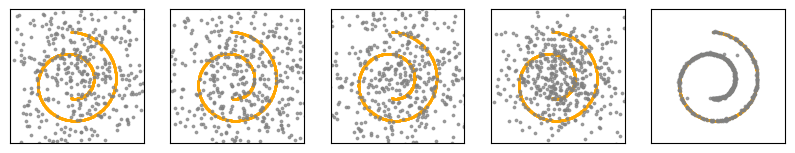

In [64]:
# intermediate steps during the forward/reverse processes
temps = [0, int(num_steps/5), int(num_steps/2), int(num_steps/2)+int(num_steps/4), int(num_steps)]
lim = 1.5
lims = [-lim, lim]

fig, ax = plt.subplots(1, len(temps), figsize=(10,2))
for i, t in enumerate(temps):
    ax[i].scatter(*gt_manifold.T, s=1, color='orange')
    ax[i].scatter(*x_rev[t].T, s=3, alpha=0.7, color='grey')
    
for a in ax:
    a.set_aspect('equal')
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)
    

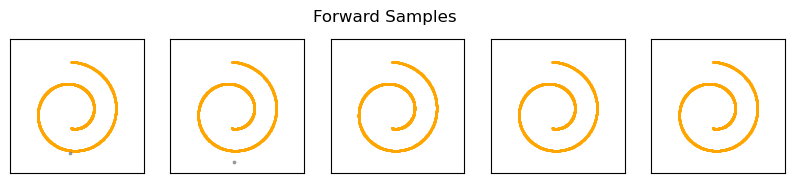

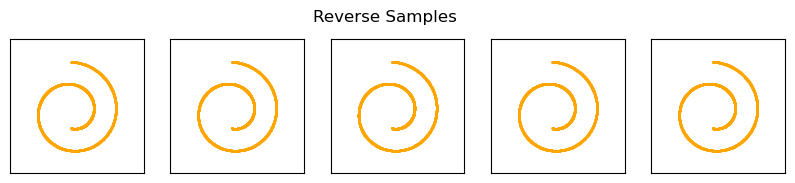

In [17]:
# intermediate steps during the forward/reverse processes
temps = [0, 25, 50, 75, 100]
lim = 1.5
lims = [-lim, lim]

fig, ax = plt.subplots(1, len(temps), figsize=(10,2))
fig.suptitle('Forward Samples')
for i, t in enumerate(temps):
    ax[i].scatter(*gt_manifold.T, s=1, color='orange')
    ax[i].scatter(*seq_fwd_x[:300,t].T, s=3, alpha=0.7, color='grey')
    
for a in ax:
    a.set_aspect('equal')
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)
    

fig, ax = plt.subplots(1, len(temps), figsize=(10,2))
fig.suptitle('Reverse Samples')
for i, t in enumerate(temps):
    ax[i].scatter(*gt_manifold.T, s=1, color='orange')
    ax[i].scatter(*seq_rev_x[200:500,t].T, s=3, alpha=0.7, color='grey')

for a in ax:
    a.set_aspect('equal')
    a.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(a)